In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## 1. Geometry Generation

Generate diverse 2D geometries for thermal simulation. The generator supports:
- Circles, rectangles, ellipses
- Polygons, L-shapes, T-shapes
- Complex composite shapes

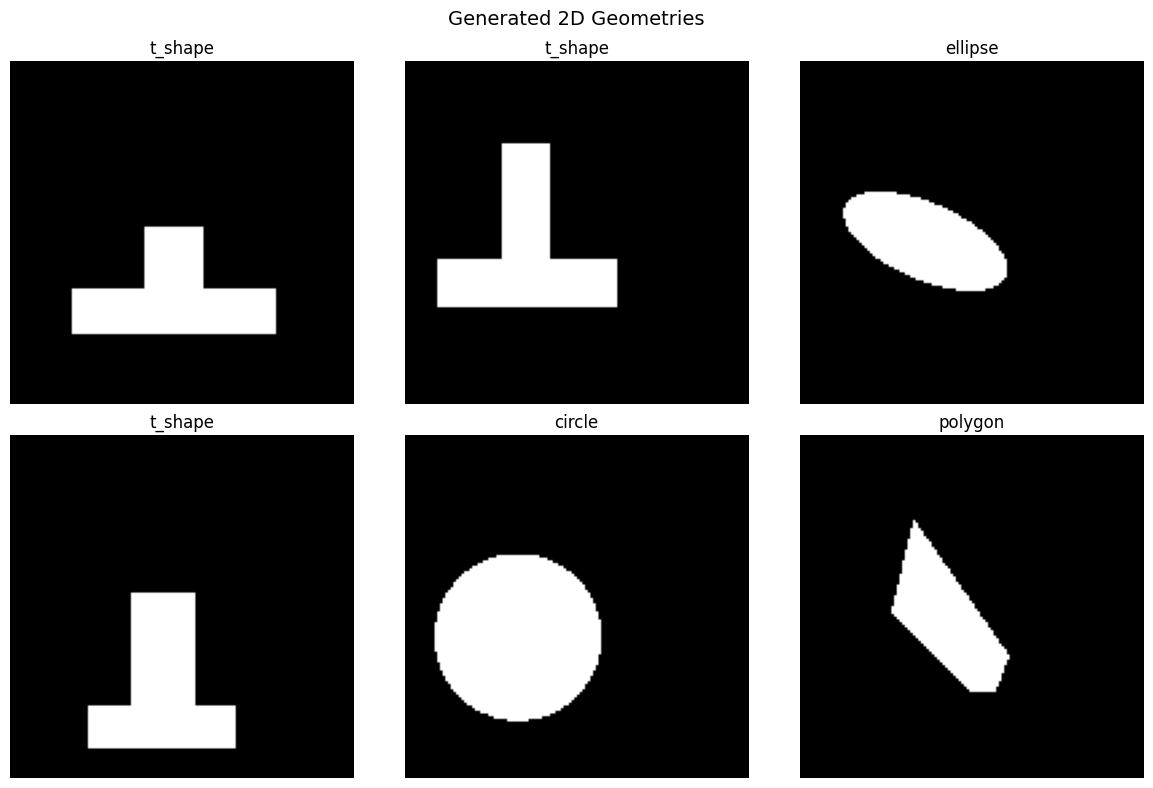

Generated 6 geometries
Each geometry has a unique hash for tracking


In [2]:
from src.geometry.generator import GeometryGenerator, GeometryConfig
from src.geometry import shapes

# Create geometry generator
config = GeometryConfig(
    resolution=128,
    shapes=['circle', 'rectangle', 'ellipse', 'l_shape', 't_shape', 'polygon']
)
generator = GeometryGenerator(config, seed=42)

# Generate sample geometries
samples = generator.generate(num_samples=6)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for idx, (ax, sample) in enumerate(zip(axes.flat, samples)):
    ax.imshow(sample['mask'], cmap='gray')
    ax.set_title(f"{sample['shape_type']}")
    ax.axis('off')
plt.suptitle('Generated 2D Geometries', fontsize=14)
plt.tight_layout()
plt.show()

print(f'Generated {len(samples)} geometries')
print(f'Each geometry has a unique hash for tracking')

## 2. Individual Shape Creation

You can also create individual shapes with specific parameters.

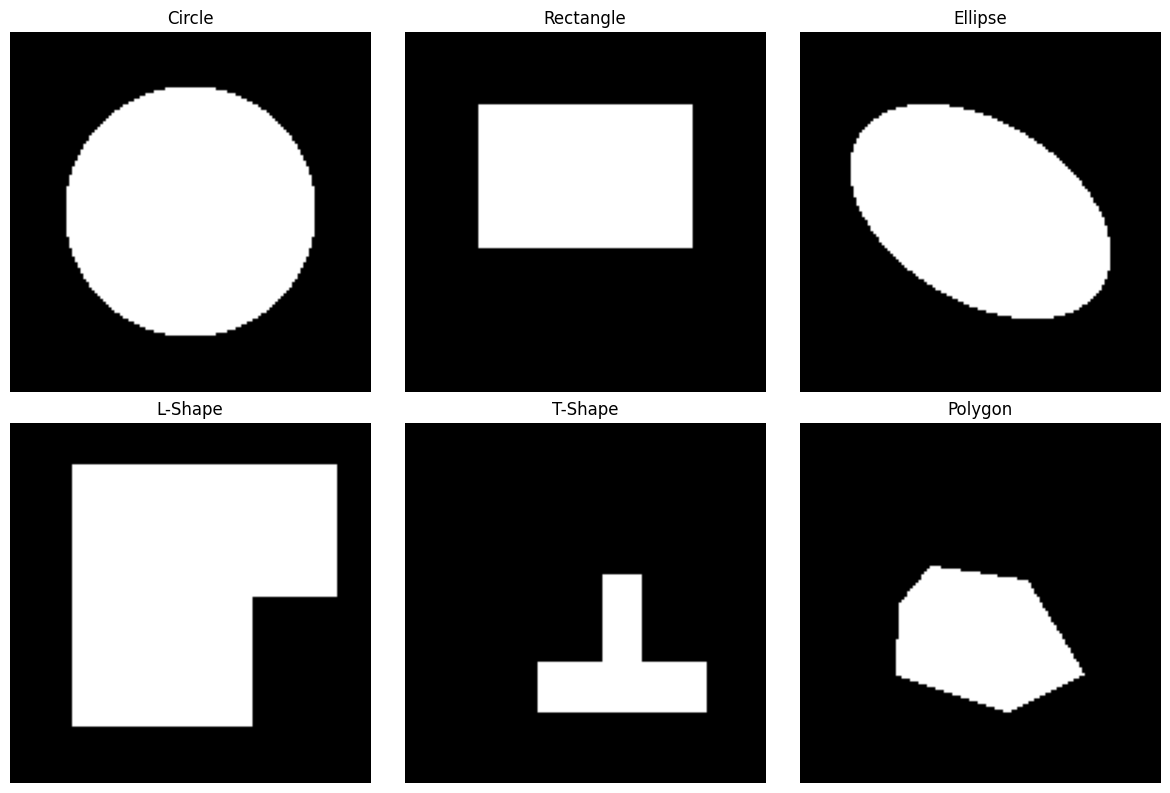

In [3]:
# Create individual shapes
resolution = 128
rng = np.random.default_rng(42)

# Create shapes with specific parameters
circle = shapes.create_circle(resolution, center=(0.5, 0.5), radius=0.35)
rectangle = shapes.create_rectangle(resolution, corner=(0.2, 0.2), size=(0.6, 0.4))
ellipse = shapes.create_ellipse(resolution, center=(0.5, 0.5), axes=(0.4, 0.25))
l_shape = shapes.create_l_shape(resolution, rng=rng)
t_shape = shapes.create_t_shape(resolution, rng=rng)
polygon = shapes.create_polygon(resolution, num_vertices=6, rng=rng)

# Display
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
shape_list = [
    (circle, 'Circle'),
    (rectangle, 'Rectangle'),
    (ellipse, 'Ellipse'),
    (l_shape, 'L-Shape'),
    (t_shape, 'T-Shape'),
    (polygon, 'Polygon')
]

for ax, (shape, name) in zip(axes.flat, shape_list):
    ax.imshow(shape, cmap='gray')
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. PINN Network Architecture

The Physics-Informed Neural Network solves the heat equation to generate ground truth data.

In [4]:
from src.pinn.network import PINNNetwork
from src.pinn.loss import HeatEquationLoss

# Create PINN network
pinn = PINNNetwork(
    hidden_layers=[128, 128, 128, 128],
    activation='tanh',
    input_dim=3,  # (t, x, y)
    output_dim=1,  # temperature
    use_fourier_features=True,
    num_fourier_frequencies=32,
)

print(f'PINN Parameters: {sum(p.numel() for p in pinn.parameters()):,}')

# Create loss function
loss_fn = HeatEquationLoss(
    alpha=0.1,  # thermal diffusivity
    weight_pde=1.0,
    weight_bc=10.0,
    weight_ic=10.0,
)

print('Heat Equation: ∂T/∂t = α * (∂²T/∂x² + ∂²T/∂y²)')

PINN Parameters: 74,753
Heat Equation: ∂T/∂t = α * (∂²T/∂x² + ∂²T/∂y²)


## 4. Neural Operator Models

The surrogate model uses neural operators to learn the solution operator of the heat equation.

In [5]:
from src.models.fno import FNO2d
from src.models.deeponet import DeepONet
from src.models.unet_fno import UNetFNO

# Fourier Neural Operator
# Takes geometry embedding + physics parameters, outputs temperature field
fno = FNO2d(
    modes=16,  # Fourier modes to retain
    width=64,  # Channel width
    num_layers=4,
    geometry_dim=512,  # Embedding dimension
    physics_dim=4,  # (alpha, source_x, source_y, intensity)
    time_steps=50,  # Output time steps
)
print(f'FNO Parameters: {sum(p.numel() for p in fno.parameters()):,}')

# DeepONet
deeponet = DeepONet(
    geometry_dim=512,
    physics_dim=4,
    branch_layers=[512, 256, 256, 128],
    trunk_layers=[128, 128, 128],
    basis_dim=128,
)
print(f'DeepONet Parameters: {sum(p.numel() for p in deeponet.parameters()):,}')

# UNet-FNO Hybrid
unet_fno = UNetFNO(
    geometry_dim=512,
    physics_dim=4,
    base_channels=64,
    time_steps=50,
    modes=16,
)
print(f'UNet-FNO Parameters: {sum(p.numel() for p in unet_fno.parameters()):,}')

FNO Parameters: 8,453,234
DeepONet Parameters: 561,281
UNet-FNO Parameters: 57,239,794


## 5. Geometry Encoder

The geometry encoder creates compact embeddings from geometry images. These are pre-computed and cached to avoid re-encoding during training.

In [6]:
from src.encoder.encoder import GeometryEncoder

# Create encoder
encoder = GeometryEncoder(
    backbone='resnet18',
    pretrained=True,
    embedding_dim=512,
    freeze_backbone=True,
)
encoder.eval()

print(f'Encoder Parameters: {sum(p.numel() for p in encoder.parameters()):,}')

# Encode a sample geometry
sample_geom = torch.from_numpy(samples[0]['mask']).float().unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    embedding = encoder(sample_geom)
    
print(f'Input shape: {sample_geom.shape}')
print(f'Embedding shape: {embedding.shape}')
print(f'Embedding stats: min={embedding.min():.3f}, max={embedding.max():.3f}, mean={embedding.mean():.3f}')

Encoder Parameters: 11,695,552
Input shape: torch.Size([1, 1, 128, 128])
Embedding shape: torch.Size([1, 512])
Embedding stats: min=-0.442, max=0.423, mean=0.006


## 6. FNO Forward Pass Demo

Demonstrate how the FNO processes geometry with embeddings.

Geometry embedding shape: torch.Size([1, 512])
Physics params shape: torch.Size([1, 4])
FNO output shape: torch.Size([1, 50, 128, 128])


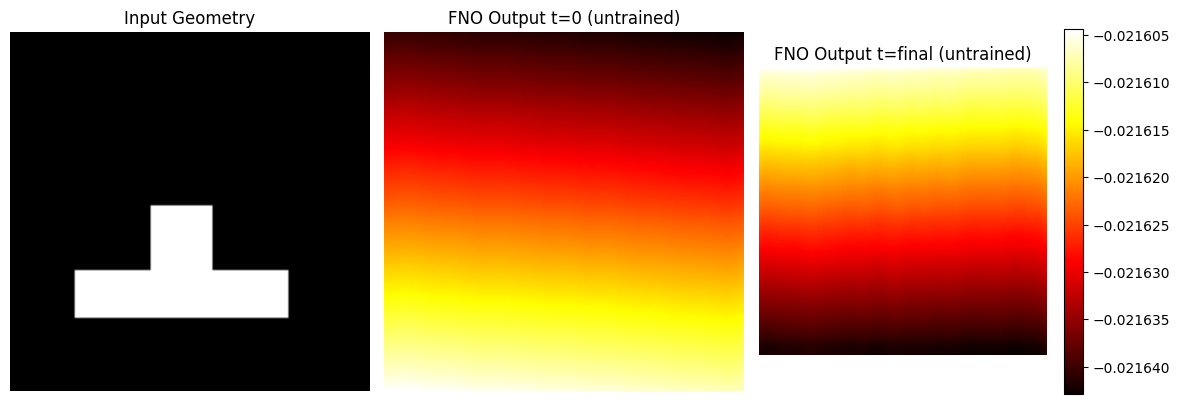

In [7]:
# Prepare input for FNO
batch_size = 1
resolution = 128

# Geometry mask
geometry = torch.from_numpy(samples[0]['mask']).float().unsqueeze(0).unsqueeze(0)

# Get embedding
with torch.no_grad():
    embedding = encoder(geometry)  # [1, 512]

# Create physics parameters (alpha, source_x, source_y, intensity)
physics_params = torch.tensor([[0.1, 0.5, 0.5, 5.0]])  # [1, 4]

print(f'Geometry embedding shape: {embedding.shape}')
print(f'Physics params shape: {physics_params.shape}')

# Forward pass (FNO takes embedding and physics, outputs temperature field)
with torch.no_grad():
    output = fno(embedding, physics_params)
    
print(f'FNO output shape: {output.shape}')

# Visualize (output is [B, T, H, W] - time steps x spatial)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(geometry[0, 0].numpy(), cmap='gray')
axes[0].set_title('Input Geometry')
axes[0].axis('off')

# Show first and last time step
axes[1].imshow(output[0, 0].numpy(), cmap='hot')
axes[1].set_title('FNO Output t=0 (untrained)')
axes[1].axis('off')

axes[2].imshow(output[0, -1].numpy(), cmap='hot')
axes[2].set_title('FNO Output t=final (untrained)')
axes[2].axis('off')

plt.colorbar(axes[2].images[0], ax=axes[2])
plt.tight_layout()
plt.show()

## 7. Visualization Tools

The visualization module provides tools for creating heatmaps and animations.

In [8]:
from src.visualization.heatmap import plot_temperature_field, plot_temporal_evolution

# Create dummy temperature field for visualization demo
time_steps = np.linspace(0, 1, 10)
resolution = 128

# Simulate heat diffusion (just for demo - not real physics)
geometry_mask = samples[0]['mask']
temperature_fields = []

for t_idx, t in enumerate(time_steps):
    # Simple Gaussian heat source spreading over time
    y, x = np.ogrid[:resolution, :resolution]
    cx, cy = resolution // 2, resolution // 2
    sigma = 10 + t * 30
    heat = np.exp(-((x - cx)**2 + (y - cy)**2) / (2 * sigma**2))
    temp = heat * geometry_mask * (1 - 0.3 * t)  # Decay over time
    temperature_fields.append(temp)

temperature_fields = np.stack(temperature_fields)

print(f'Temperature field shape: {temperature_fields.shape}')
print(f'Time steps: {len(time_steps)}')

Temperature field shape: (10, 128, 128)
Time steps: 10


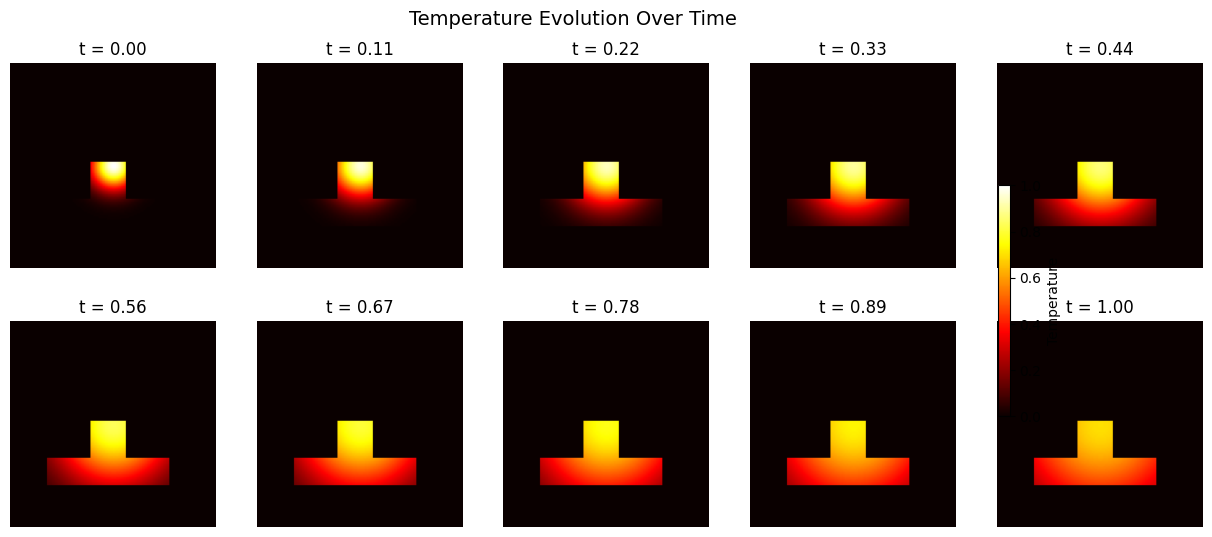

In [9]:
# Plot temperature evolution at different time steps
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, ax in enumerate(axes.flat):
    im = ax.imshow(temperature_fields[idx], cmap='hot', vmin=0, vmax=1)
    ax.set_title(f't = {time_steps[idx]:.2f}')
    ax.axis('off')

plt.suptitle('Temperature Evolution Over Time', fontsize=14)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Temperature')
plt.subplots_adjust(top=0.9, right=0.92)  # Adjust layout to avoid warning
plt.show()

## 8. Training Configuration

Review the training configuration from the YAML file.

In [10]:
from src.utils.config import load_config

# Load training config
try:
    train_config = load_config('../configs/training.yaml')
    print('Training Configuration:')
    print(f"  Model type: {train_config['training']['model']['type']}")
    print(f"  Batch size: {train_config['training']['data']['batch_size']}")
    print(f"  Learning rate: {train_config['training']['optimizer']['lr']}")
    print(f"  Epochs: {train_config['training']['epochs']}")
except FileNotFoundError:
    print('Config file not found - using defaults')

Training Configuration:
  Model type: fno
  Batch size: 16
  Learning rate: 0.001
  Epochs: 200


## 9. Metrics

The evaluation uses several metrics to assess model performance.

In [11]:
from src.utils.metrics import compute_mse, compute_relative_l2, compute_max_error

# Create dummy predictions and targets
target = temperature_fields
prediction = target + np.random.normal(0, 0.05, target.shape)  # Add some noise

# Compute metrics
mse = compute_mse(prediction, target)
rel_l2 = compute_relative_l2(prediction, target)
max_err = compute_max_error(prediction, target)

print('Evaluation Metrics (simulated):')
print(f'  MSE: {mse:.6f}')
print(f'  Relative L2 Error: {rel_l2:.4f}')
print(f'  Max Error: {max_err:.4f}')

Evaluation Metrics (simulated):
  MSE: 0.002490
  Relative L2 Error: 0.3236
  Max Error: 0.2424


## 10. Next Steps

To train and use the full model:

1. **Generate Dataset**:
   ```bash
   python scripts/generate_dataset.py --config configs/dataset.yaml
   ```

2. **Train Model**:
   ```bash
   python scripts/train.py --config configs/training.yaml
   ```

3. **Evaluate**:
   ```bash
   python scripts/evaluate.py --config configs/inference.yaml
   ```

4. **Run Inference**:
   ```bash
   python scripts/inference.py --geometry path/to/geometry.png --output output.png
   ```

5. **Export to ONNX**:
   ```bash
   python scripts/export_onnx.py --checkpoint outputs/checkpoints/best_model.pt
   ```

In [12]:
print('Demo completed successfully!')
print('\nProject Structure:')
print('  - src/geometry/    : Geometry generation')
print('  - src/pinn/        : PINN solver for ground truth')
print('  - src/encoder/     : Geometry encoder')
print('  - src/models/      : Neural operators (FNO, DeepONet, UNet-FNO)')
print('  - src/training/    : Training pipeline')
print('  - src/inference/   : Fast inference')
print('  - src/visualization/: Visualization tools')
print('  - scripts/         : CLI scripts')

Demo completed successfully!

Project Structure:
  - src/geometry/    : Geometry generation
  - src/pinn/        : PINN solver for ground truth
  - src/encoder/     : Geometry encoder
  - src/models/      : Neural operators (FNO, DeepONet, UNet-FNO)
  - src/training/    : Training pipeline
  - src/inference/   : Fast inference
  - src/visualization/: Visualization tools
  - scripts/         : CLI scripts
